In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
512
512
2000
512
512


In [5]:
num_elements=len(scDataset)
dim=high_var_gene
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 2000


In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [11]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        # if epoch<20:
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        # else:
        #     data=data.to('cuda')
        #     embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [14]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    # if epoch %20 ==0:
    #     embeddings=np.empty((0,mlp.rep_dim))
    #     model.eval()
    #     with torch.no_grad():
    #         for step, (x, y) in enumerate(scGenDataLoader):
    #             x=x.to('cuda')
    #             embedding=model.forward_embedding(x).cpu().detach().numpy()                 
    #             embeddings=np.row_stack((embeddings,embedding))
    #             memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    # nmi, ari, f, acc = test()
    # accs.append(acc)
    # aris.append(ari)
    # nmis.append(nmi)
    # fs.append(f)
    # print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    # print('========'*8+'\n')

Step [0/16]	 loss_instance: 6.913857460021973	 loss_cluster: 3.2991929054260254
Step [2/16]	 loss_instance: 6.712862491607666	 loss_cluster: 3.298283576965332
Step [4/16]	 loss_instance: 6.383283615112305	 loss_cluster: 3.2948877811431885
Step [6/16]	 loss_instance: 6.3004961013793945	 loss_cluster: 3.2854509353637695
Step [8/16]	 loss_instance: 6.1375861167907715	 loss_cluster: 3.265096664428711
Step [10/16]	 loss_instance: 5.950763702392578	 loss_cluster: 3.230727434158325
Step [12/16]	 loss_instance: 5.897871971130371	 loss_cluster: 3.1586647033691406
Step [14/16]	 loss_instance: 5.796322822570801	 loss_cluster: 3.0672667026519775

Epoch [1/300]	 Loss: 9.495668607950211 

Step [0/16]	 loss_instance: 5.753137588500977	 loss_cluster: 2.9943418502807617
Step [2/16]	 loss_instance: 5.756695747375488	 loss_cluster: 2.8654565811157227
Step [4/16]	 loss_instance: 5.723991870880127	 loss_cluster: 2.768895149230957
Step [6/16]	 loss_instance: 5.684011459350586	 loss_cluster: 2.64913940429687

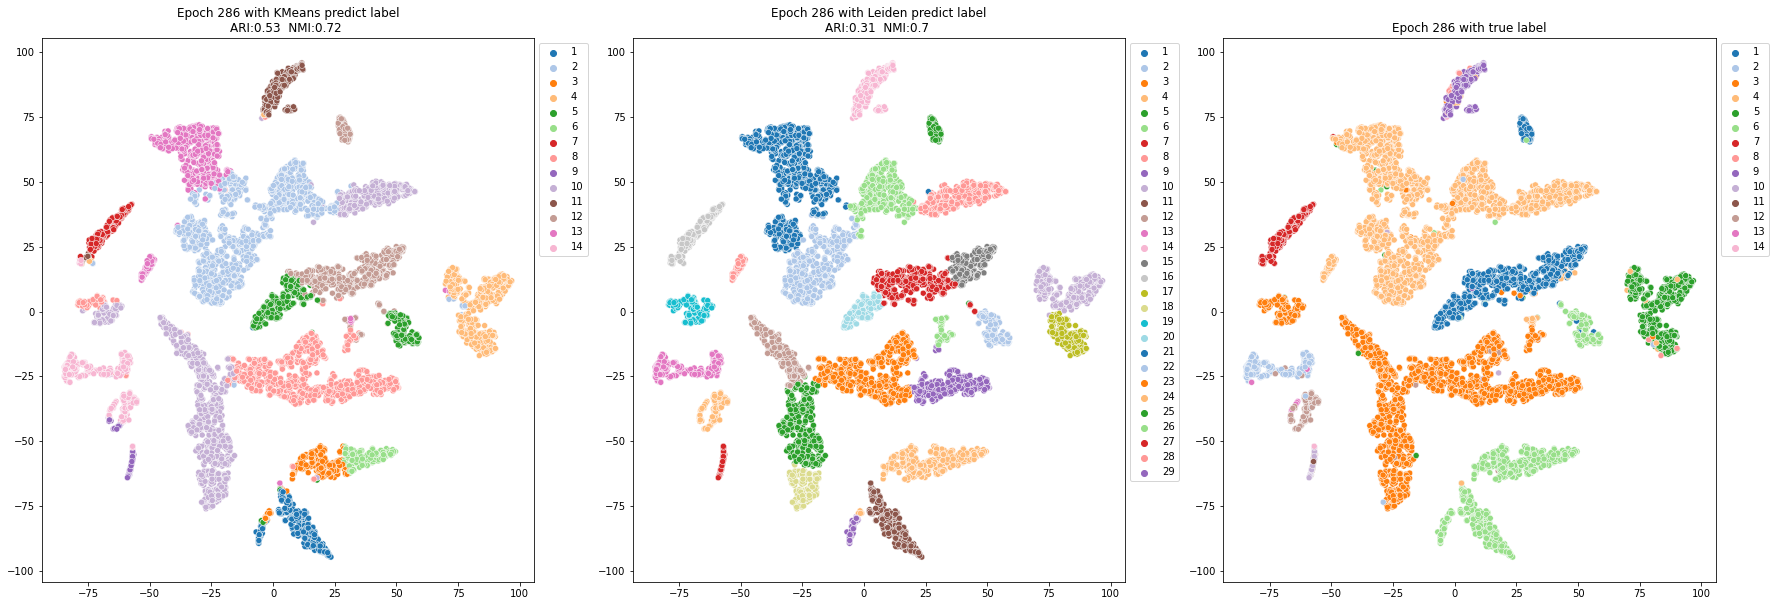

In [15]:
from evaluation import evaluation_tools
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim,args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-static-bank\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)
# print(results)

In [9]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=False)
# evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=286)
print(results)

{'kmeans_ari': 0.5485744616897491, 'kmeans_nmi': 0.7302188283689908, 'kmeans_sil': 0.35874087, 'kmeans_cal': 2820.0743903193, 'leiden_ari': 0.3036244818629452, 'leiden_nmi': 0.693425300566485, 'leiden_sil': 0.37151045, 'leiden_cal': 2006.463899696071}
